# 기본 패키지 임포트

In [ ]:
import numpy as np
import pandas as pd
import re
import json
import os
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import requests
import time
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from pykospacing import Spacing
from tensorflow.keras.models import load_model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import seaborn as sns
from eunjeon import Mecab
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
class All_process():
    def __init__(self, movie, model):
        self.spacing = Spacing()
        self.mecab = Mecab()
        with open('Tokenizer.pickle', 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        self.stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','흠','아','더']
        self.movie = movie
        
        self.X_train = None
        self.y_train = None
        
        self.max_len = 50
        
        self.models = model
        
    def data_cleaning(self, review):
        # 1. 한글 및 공백을 제외한 모든 문자 제거 -> 한글만 남기겠다.
        review_text = re.sub("[^가-힣ㄱ-ㅎㅏ - | \\s]", "", review)

        # 2. 띄어쓰기 규칙
        review_text = self.spacing(review_text)

        # 3. mecab 객체를 활용해 형태소 단위로 문장을 나눈다(tokenzing)
        word_review = self.mecab.morphs(review_text)

        # 4. 불용어 제거하기
        word_review = [token for token in word_review if not token in self.stop_words]

        return word_review
    
    def clean_data_get(self):
        clean_train_review = []
        for review in tqdm(self.movie['Review']):
            clean_train_review.append(self.data_cleaning(review))
        
        ## 지우면 안됨 => [] 로 저장
        for idx, clean in enumerate(clean_train_review):
            if clean == None: clean_train_review[idx] = []
        
        self.movie['Review_clean'] = clean_train_review
        return
    
    def encoding(self):
        self.X_train = self.movie['Review_clean']
        
        self.X_train = self.tokenizer.texts_to_sequences(self.X_train)
        
        self.X_train = pad_sequences(self.X_train, maxlen = self.max_len)
        
        print("shape : ", self.X_train.shape)
        return
    
    def sentiment_predict(self):     
        self.clean_data_get()
        
        self.encoding()
        
        # cnn 모델로 돌리기
        result = self.models.predict(self.X_train)
        result = [1 if r>0.5 else 0 for r in result]
        
        self.movie['P/N'] = result
        
        return
        

# 키워드 추출 클래스

In [ ]:
def no_space(text):
    text1 = re.sub('&nbsp;|&nbsp;|\n|\t|\r', '', text)
    text2 = re.sub('\n\n','', text1)
    return text2

def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

def load_stopwords(basepath):
    print("불용어셋을 가져오고 있습니다.")
    with open(basepath+'stopwords.txt', 'r') as f:
        list_file = f.readlines()
    return list_file[0].split(",")


class Review_keyword:
    def __init__(self, minimum_count:int)->None:
        self.basepath = input("데이터를 저장하고 불러올 기본 경로를 입력해주세요   ")
        self.minimum_count = minimum_count
        self.word_list =  None
        self.name = None
        self.url = None
        self.data = None
        self.stopwords = load_stopwords(self.basepath)
        self.vocab = None
        
    def search(self) :
        self.name= input("어떤 영화를 검색하시겠습니까? ")
        url = f'https://movie.naver.com/movie/search/result.naver?query={self.name}&section=all&ie=utf8'        
        res = requests.get(url)
        index = 1
        user_dic = {}
        if res.status_code == 200:
            soup=BeautifulSoup(res.text,'lxml')
            for href in soup.find("ul", class_="search_list_1").find_all("li"): 
                print(f"=============={index}번 영화===============")
                print(href.dl.text[:-2])
                user_dic[index] = int(href.dl.dt.a['href'][30:])
                index = index+1
        movie_num = int(input("몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : "))
        code = user_dic[movie_num]
        base_url = f'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={code}&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=sympathyScore&page='
        self.url = base_url+'{}'
        
    def save_and_load(self,dataframe):
        dataframe.to_csv(self.basepath+f'{self.name}review.csv' , index= False)
        df = pd.read_csv(self.basepath+f'{self.name}review.csv')
        df = df.dropna()
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        return df
            
    def crawl_review(self):
        res = requests.get(self.url)
        if res.status_code == 200:
            soup=BeautifulSoup(res.text,'lxml')
            total = soup.select('div.score_total > strong > em')[0].text
            pages = int(total.replace(',','')[:-1]) #17,921 > 17921로 변환 후 캐스팅
            print()
            print(f"{pages}개의 페이지에서 {self.name} 영화 리뷰를 모으고 있습니다.")
            time.sleep(1)
        comments = []
        stars = []
        for page in tqdm(range(1,pages+1)):
            url = self.url.format(page)
            res = requests.get(url)
            if res.status_code == 200:
                soup=BeautifulSoup(res.text,'lxml')
                star =  soup.select('div.score_result > ul > li > div.star_score > em')
                tds = soup.select('div.score_result > ul > li > div.score_reple > p > span')
                for st in star:
                    stars.append(int(st.text))
                for cmt in tds:
                    if cmt.text != '관람객' and cmt.text !='스포일러가 포함된 감상평입니다. 감상평 보기':
                        comments.append(no_space(cmt.text))
                if(len(comments) != len(stars)):
                    print(url)
                    break 
        assert len(comments) == len(stars)
        self.data = self.save_and_load(pd.DataFrame({"Review":comments, "Rank":stars}))
       
    def make_wordlist(self,reviews): #reviews = " ".join(data['Review'].tolist())
        print("리뷰들을 모아 분석하는 중입니다.....")
        #정규표현식 적용
        print("데이터 정제 중....")
        words = extract_word(reviews)
        #형태소 추출
        print("형태소 추출 중....")
        okt = Okt()
        words = okt.morphs(words,stem=True)
        #한글자 제거
        print("한글자 제거 중....")
        words = [x for x in words if len(x)>1 or x =='닉']
        #불용어 제거
        print("불용어 제거 중....")
        words = [x for x in words if x not in self.stopwords]
        words = [x if (x!='재밌다' and x!='재미잇다' and x!= '재밋다') else '재미있다' for x in words]
        #최소횟수 미만 제거
        print("의미있는 단어리스트 생성 중....")
        time.sleep(1)
        minimum_count = 3
        final = []
        for i in tqdm(range(len(words))):
            tmp = words[i]
            if words.count(tmp) >= minimum_count:
                final.append(tmp)
        self.word_list = set(final) #조건을 만족하는 단어 리스트

    def preprocess(self,text):
        text = extract_word(text)
        okt = Okt()
        text = okt.morphs(text, stem = True)
        text = [x for x in text if x in self.word_list]
        return text

    def tf_idf(self):
        vectorizer = CountVectorizer(tokenizer = lambda x: self.preprocess(x))
        data_features = vectorizer.fit_transform(self.data['Review'].tolist())
        tfidf_vectorizer = TfidfTransformer()
        tf_idf_vect = tfidf_vectorizer.fit_transform(data_features)
        self.vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
        print("벡터 변환완료")
        return tf_idf_vect
        
    def ready_data(self):
        self.search()
        self.crawl_review()
        time.sleep(0.5)
        print("리뷰를 모두 불러왔습니다.")
        
    def load_data(self, filename):
        filepath = self.basepath+filename
        df = pd.read_csv(filepath)
        df = df.dropna()
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        self.name = filename[:-16]
        self.data =df
                
    def clean_data(self):
        print("리뷰데이터 전처리를 시작합니다.")
        self.make_wordlist(" ".join(self.data['Review'].tolist()))
        time.sleep(0.5)
        print("전처리 작업을 완료하였습니다.")
        
    def extract(self):
        print("데이터를 학습하고 있습니다.")
        
        CNN = load_model('CNN_model_hyper2.h5')

        # moive => 영화 df, CNN=> 위에서 LOAD한 모델
        process = All_process(self.data, CNN)
        process.sentiment_predict()

        ## df 얻으려면
        self.data = process.movie[['Review','P/N']]
        
        
        
        min_cnt = min(self.data['P/N'].value_counts().tolist())
        positive_random_idx = self.data[self.data['P/N']==1].sample(min_cnt, random_state=40).index.tolist()
        negative_random_idx = self.data[self.data['P/N']==0].sample(min_cnt, random_state=40).index.tolist()
        random_idx = positive_random_idx + negative_random_idx
        random.shuffle(random_idx)
        print("데이터 셔플 완료")
        tf_idf_vect = self.tf_idf()
        x = tf_idf_vect[random_idx]
        y = self.data['P/N'][random_idx]
        model = LogisticRegression()
        model.fit(x, y)
        print("데이터 학습 완료")
        y_pred = model.predict(x)
        pos_index = sorted(((value, index) for index, value in enumerate(model.coef_[0])), reverse = True)
        neg_index = sorted(((value, index) for index, value in enumerate(model.coef_[0])), reverse = False)
        print("키워드 추출 완료")
        return pos_index, neg_index
    
    def visualize(self, pos, neg):
        #폰트설정(한글 깨짐)
        import math
        from matplotlib import font_manager, rc
        font_name = font_manager.FontProperties(fname="font/NanumSquare.ttf").get_name()
        rc('font', family=font_name)
        import matplotlib
        matplotlib.rcParams['axes.unicode_minus'] = False
        #긍부정 비율 시각화
        ratio = [self.data['P/N'].tolist().count(x) for x in [1,0]]
        labels = ['Positive', 'Negative']
        colors = ['#ff9999', '#8fd9b6']
        wedgeprops={'width': 0.2, 'edgecolor': 'w', 'linewidth': 5}
        plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
        plt.title(f"영화 {self.name} 리뷰 비중")
        plt.show()
        
        
        #주요 키워드 시각화
        pos_label = [self.vocab[coef[1]] for coef in pos[:5]]
        pos_value = [coef[0] for coef in pos[:5]]
        neg_label = [self.vocab[coef[1]] for coef in neg[:5]]
        neg_value = [coef[0] for coef in neg[:5]]
        x = np.arange(5)

        graphlimit = round(max(pos_value+neg_value))+1
        plt.subplot(1,2,1)
        bar1 = plt.barh(neg_label,neg_value, color = "#8fd9b6")

        plt.xlim([-graphlimit,0]) 
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        label_ind = 0
        for rect in bar1:
            witdh = rect.get_width()
            posx = witdh*1.05
            posy = rect.get_y()+rect.get_height()*0.5
            plt.text(posx, posy, neg_label[label_ind], rotation=0, ha='right', va='center')
            label_ind = label_ind+1

        plt.subplot(1,2,2)
        bar2 = plt.barh(pos_label, pos_value, color="#ff9999")
        plt.xlim([0,graphlimit]) 
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        label_ind = 0
        for rect in bar2:
            witdh = rect.get_width()
            posx = witdh*1.05
            posy = rect.get_y()+rect.get_height()*0.5
            plt.text(posx, posy, pos_label[label_ind], rotation=0, ha='left', va='center')
            label_ind = label_ind+1


        plt.suptitle(f'{self.name} 연관어 BEST 5',fontweight ="bold")
        #plt.subplots_adjust(left=0, bottom=0,  right=1.5, top=0.7, wspace=0.0, hspace=0)
        plt.tight_layout()

In [ ]:
test= Review_keyword(minimum_count =3)
test.load_data('캣츠와독스review.csv')

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.


In [ ]:
test.clean_data()
pos,neg = test.extract()

리뷰데이터 전처리를 시작합니다.
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|█████████████████████████████████████████████████████████████████████████████| 723/723 [00:00<00:00, 51779.76it/s]


전처리 작업을 완료하였습니다.
데이터를 학습하고 있습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:11<00:00, 21.25it/s]


shape :  (237, 50)
데이터 셔플 완료
벡터 변환완료
데이터 학습 완료
키워드 추출 완료


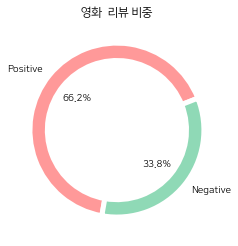

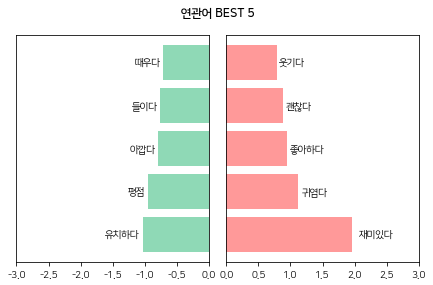

In [ ]:
test.visualize(pos,neg)

In [ ]:
cats = Review_keyword(minimum_count = 3)
cats.ready_data()


데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.
어떤 영화를 검색하시겠습니까? 캣츠와독스
==============1번 영화===============

캣츠 앤 독스 2 (Cats & Dogs: The Revenge Of Kitty Galore)

7.58 (참여 248명)

액션, 코미디, 가족| 미국, 오스트레일리아|82분 |2010
감독 : 브래드 페이튼|출연 : 크리스 오도넬, 베트 미들러, 닉 놀테, 제임스 마스던, 크리스티나 애플게이트, 캣 윌리엄스, 닐 패트릭 해리스, 션 헤이즈, 월리스 쇼운, 로저 무어, 조 판톨리아노, 마이클 클락 던칸


==============2번 영화===============

캣츠 앤 독스 (Cats & Dogs)

7.83 (참여 184명)

액션, 모험, 코미디, 가족| 미국, 오스트레일리아|85분 |2001
감독 : 로렌스 구터먼|출연 : 알렉 볼드윈, 마이클 클락 던칸, 션 헤이즈, 존 로비츠, 토비 맥과이어, 조 판톨리아노, 수잔 서랜든


==============3번 영화===============

오브 캣츠, 독스, 팜 애니멀즈 앤 사시미 (Of Cats, Dogs, Farm Animals and Sashimi)
다큐멘터리| 필리핀|77분 |2015
감독 : 페리 다이즌

몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : 1

24개의 페이지에서 캣츠와독스 영화 리뷰를 모으고 있습니다.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.43it/s]


리뷰를 모두 불러왔습니다.


In [ ]:
cats.clean_data()
pos,neg = cats.extract()

리뷰데이터 전처리를 시작합니다.
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|█████████████████████████████████████████████████████████████████████████████| 723/723 [00:00<00:00, 55629.62it/s]


전처리 작업을 완료하였습니다.
데이터를 학습하고 있습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:10<00:00, 21.76it/s]


shape :  (237, 50)
데이터 셔플 완료
벡터 변환완료
데이터 학습 완료
키워드 추출 완료


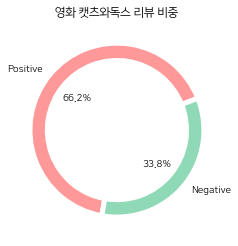

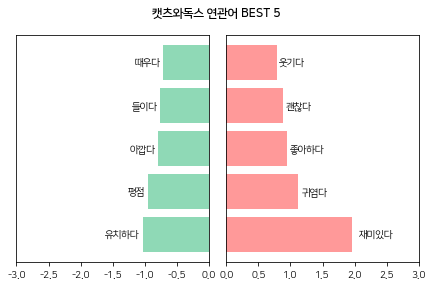

In [ ]:
cats.visualize(pos,neg)



In [ ]:
iron = Review_keyword(minimum_count = 3)
iron.ready_data()
iron.clean_data()
pos,neg = iron.extract()

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.
어떤 영화를 검색하시겠습니까? 아이언맨2
==============1번 영화===============

아이언맨 2 (Iron Man 2)

7.37 (참여 6573명)

SF, 모험, 액션| 미국|125분 |2010
감독 : 존 파브로|출연 : 로버트 다우니 주니어, 기네스 팰트로, 돈 치들, 스칼릿 조핸슨, 미키 루크


몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : 1

650개의 페이지에서 아이언맨2 영화 리뷰를 모으고 있습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:20<00:00,  8.05it/s]


리뷰를 모두 불러왔습니다.
리뷰데이터 전처리를 시작합니다.
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|██████████████████████████████████████████████████████████████████████████| 26828/26828 [00:21<00:00, 1256.95it/s]


전처리 작업을 완료하였습니다.
데이터를 학습하고 있습니다.
데이터 라벨링 완료
데이터 셔플 완료
벡터 변환완료
데이터 학습 완료
키워드 추출 완료


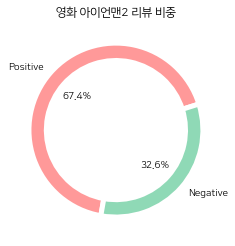

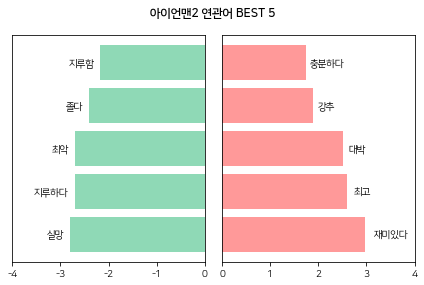

In [ ]:
iron.visualize(pos,neg)

In [ ]:
iron = Review_keyword(minimum_count = 3)
iron.ready_data()

iron.clean_data()
pos,neg = iron.extract()

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.
어떤 영화를 검색하시겠습니까? 아이언맨2
==============1번 영화===============

아이언맨 2 (Iron Man 2)

7.37 (참여 6573명)

SF, 모험, 액션| 미국|125분 |2010
감독 : 존 파브로|출연 : 로버트 다우니 주니어, 기네스 팰트로, 돈 치들, 스칼릿 조핸슨, 미키 루크


몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : 1

650개의 페이지에서 아이언맨2 영화 리뷰를 모으고 있습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:19<00:00,  8.18it/s]


리뷰를 모두 불러왔습니다.
리뷰데이터 전처리를 시작합니다.
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|██████████████████████████████████████████████████████████████████████████| 26828/26828 [00:23<00:00, 1164.21it/s]


전처리 작업을 완료하였습니다.
데이터를 학습하고 있습니다.
데이터 라벨링 완료
데이터 셔플 완료
벡터 변환완료
데이터 학습 완료
키워드 추출 완료


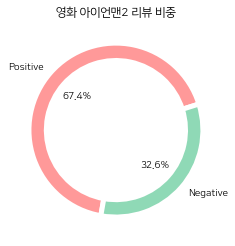

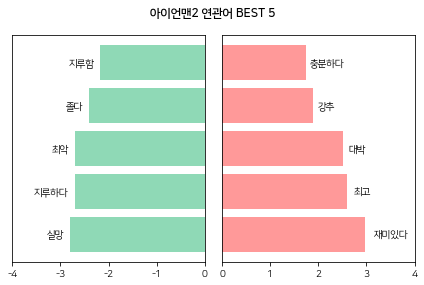

In [ ]:
iron.visualize(pos,neg)

In [ ]:
alive = Review_keyword(minimum_count = 3)
alive.ready_data()

alive.clean_data()
pos,neg = alive.extract()

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.
어떤 영화를 검색하시겠습니까? 리얼
==============1번 영화===============

리얼: 라 히스토리아 데트라스 델 플랜 (Real: O Plano por Tras da Historia)
드라마| 브라질|90분 |2017
감독 : 로드리고 비텐코트

==============2번 영화===============

리얼 (REAL)

4.25 (참여 12632명)

액션, 느와르| 한국|137분 |2016
감독 : 이사랑|출연 : 김수현, 이성민, 성동일


==============3번 영화===============

리얼 스틸 (Real Steel)

9.06 (참여 12308명)

액션, 드라마, SF| 미국|127분 |2011
감독 : 숀 레비|출연 : 휴 잭맨, 에반젤린 릴리, 다코타 고요


==============4번 영화===============

GROW: 인피니트의 리얼 청춘 라이프

9.05 (참여 670명)

한국|82분 |2014
감독 : 김진수|출연 : 인피니트

==============5번 영화===============

랭고리얼 (The Langoliers)
TV영화| 미국|180분 |1995
감독 : 톰 홀랜드|출연 : 패트리샤 웨티그, 딘 스톡웰, 데이빗 모스

몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : 2

1240개의 페이지에서 리얼 영화 리뷰를 모으고 있습니다.


  7%|█████▉                                                                          | 92/1240 [00:10<02:07,  9.01it/s]


KeyboardInterrupt: 

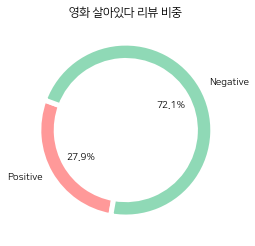

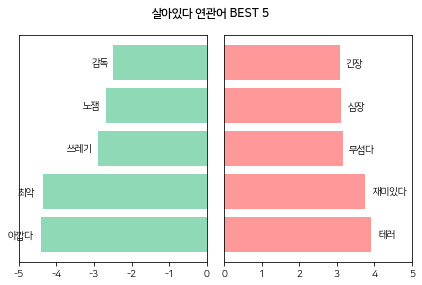

In [ ]:
alive.visualize(pos,neg)